<a href="https://colab.research.google.com/github/Satwikram/Deep-Learning-Implementations/blob/master/GAN/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GAN
Author: Satwik Ram K

## Importing Dependencies

In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import tqdm
import matplotlib.pyplot as plt

In [8]:
# To generate GIFs
!pip install -q imageio

In [10]:
import PIL
import imageio
import glob
import time

from IPython import display

## Loading and Preparing the dataset

In [11]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [13]:
X_train.shape

(60000, 28, 28)

In [14]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5  # Normalize the images to [-1, 1] 

In [15]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [16]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## The Generator

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [25]:
def make_generator_model():
  model = Sequential()
  model.add(Dense(7*7*256, use_bias = False, input_shape = (100, )))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5,5), strides = (1, 1), padding = 'same', use_bias = False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model


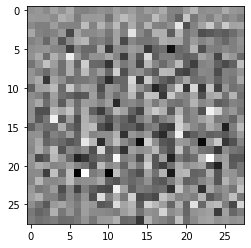

In [26]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator